In [1]:
# Louding the necessary packeges
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import mean_squared_error
import geopandas as gpd
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pyproj
from geopandas import datasets, GeoDataFrame, read_file

In [116]:
# Change the current working directory
os.chdir('C:/Users/Sbals/Documents/Semester4/DataScienceTechnologyandSystemsPG11523/data')

# read the data
df = pd.read_csv('zomato_df_final_data.csv')

# Show the first 5 rows
df.head(5)

,address,cost,cuisine,lat,link,lng,phone,rating_number,rating_text,subzone,title,type,votes,groupon,color,cost_2,cuisine_color
0,"371A Pitt Street, CBD, Sydney",50.0,"['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean']",-33.876059,https://www.zomato.com/sydney/sydney-madang-cbd,151.207605,02 8318 0406,4.0,Very Good,CBD,Sydney Madang,['Casual Dining'],1311.0,False,#e15307,5.243902,#6f706b
1,"Shop 7A, 2 Huntley Street, Alexandria, Sydney",80.0,"['Cafe', 'Coffee and Tea', 'Salad', 'Poké']",-33.910999,https://www.zomato.com/sydney/the-grounds-of-a...,151.193793,02 9699 2225,4.6,Excellent,"The Grounds of Alexandria, Alexandria",The Grounds of Alexandria Cafe,['Café'],3236.0,False,#9c3203,7.560976,#6f706b
2,"Level G, The Darling at the Star, 80 Pyrmont ...",120.0,['Japanese'],-33.867971,https://www.zomato.com/sydney/sokyo-pyrmont,151.195210,1800 700 700,4.9,Excellent,"The Star, Pyrmont",Sokyo,['Fine Dining'],1227.0,False,#7f2704,10.650407,#6f706b
3,"Sydney Opera House, Bennelong Point, Circular...",270.0,['Modern Australian'],-33.856784,https://www.zomato.com/sydney/bennelong-restau...,151.215297,02 9240 8000,4.9,Excellent,Circular Quay,Bennelong Restaurant,"['Fine Dining', 'Bar']",278.0,False,#7f2704,22.235772,#4186f4
4,"20 Campbell Street, Chinatown, Sydney",55.0,"['Thai', 'Salad']",-33.879035,https://www.zomato.com/sydney/chat-thai-chinatown,151.206409,02 8317 4811,4.5,Excellent,Chinatown,Chat Thai,['Casual Dining'],2150.0,False,#a83703,5.630081,#6f706b


#### Through the initial exploration of the data set, it was found that the variables "cuisine" and "type" have multiple values in lists for each observation. In order to properly extract data from each observation, this problem must first be addressed by deconstructing these lists to be recognized as values.

# Part A:

In [117]:
# Get lists represents the numerical and categorical columns to be used for filtration when necessary.
numerical_variables = []
categorical_variables = []
for colname, coltype in df.dtypes.iteritems():
    if coltype == 'float64': numerical_variables.append(colname)
    elif coltype == 'object': categorical_variables.append(colname)
    else: numerical_variables.append(colname)

# remove 'lat', 'lng' as to avoid treating them
numerical_variables = [i for i in numerical_variables if i not in ('lat', 'lng')]
print(numerical_variables, categorical_variables)

['cost', 'rating_number', 'votes', 'groupon', 'cost_2'] ['address', 'cuisine', 'link', 'phone', 'rating_text', 'subzone', 'title', 'type', 'color', 'cuisine_color']


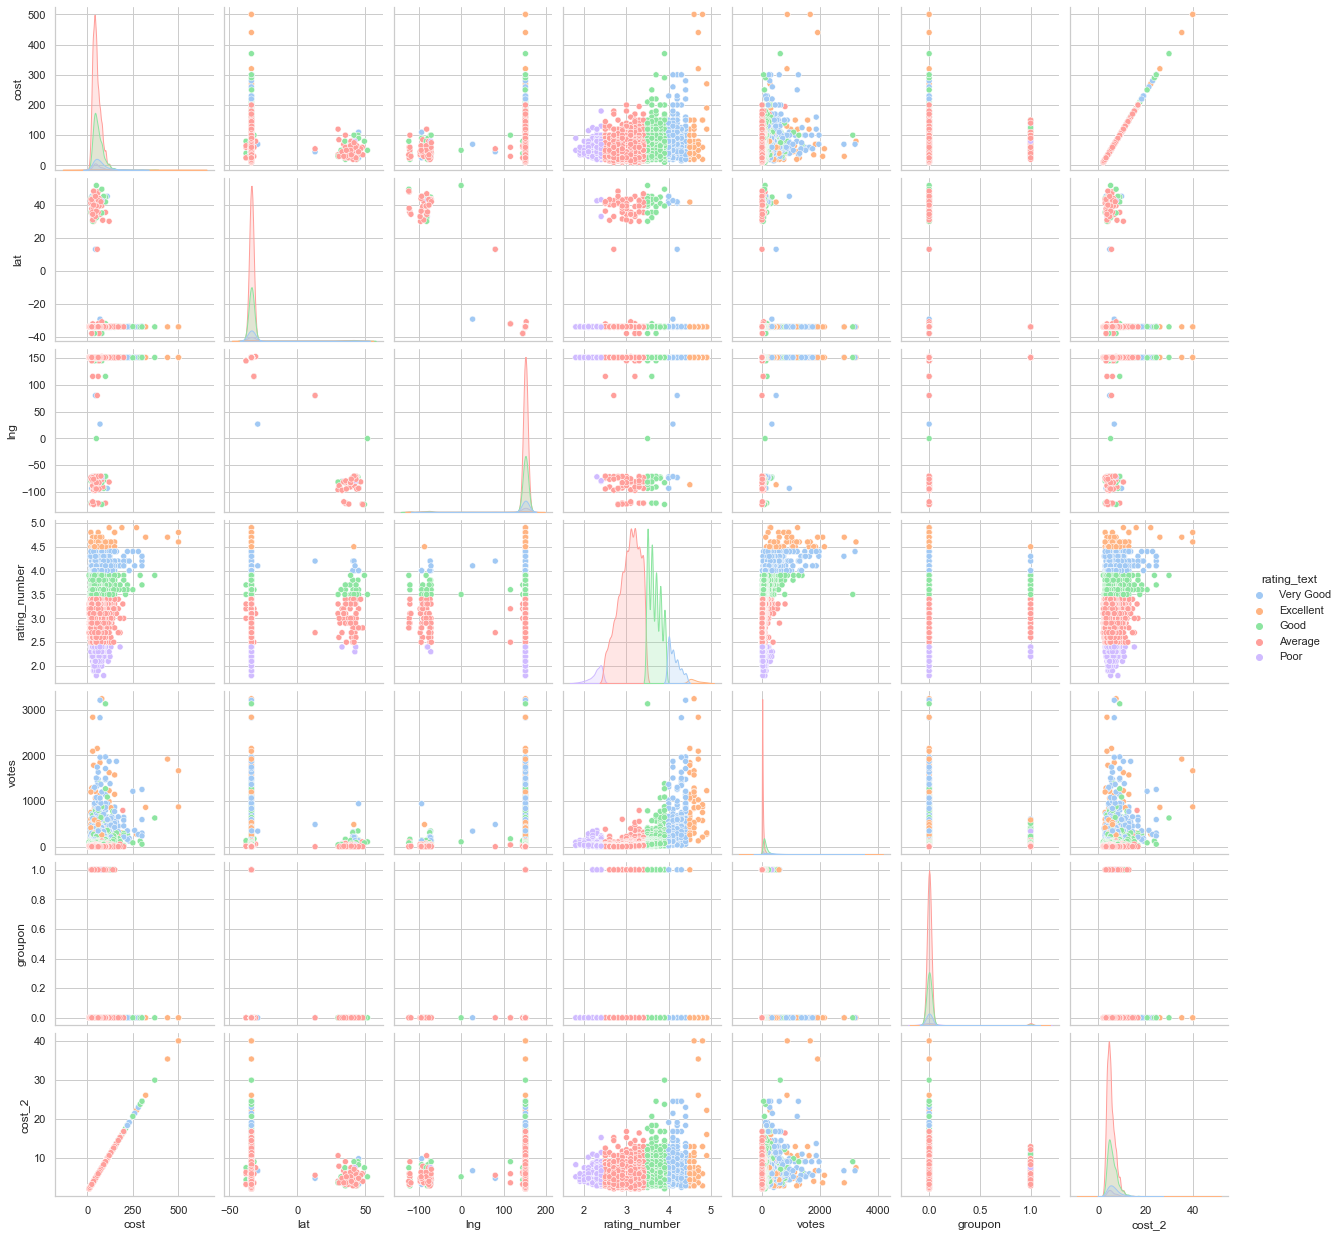

In [118]:
# pair plot for the numerical variables
sns.pairplot(df, hue = 'rating_text')

#### It is clear that except for the 'cost' and 'cost_2' variables, all the variables do not have good relations with each other or with the 'rating_number' variables, which we will use as a predicted variable in the modelling step. Regarding the distribution, we find that all variables except for the 'rating_number' variable have a nearly normal distribution, but are very skewed.

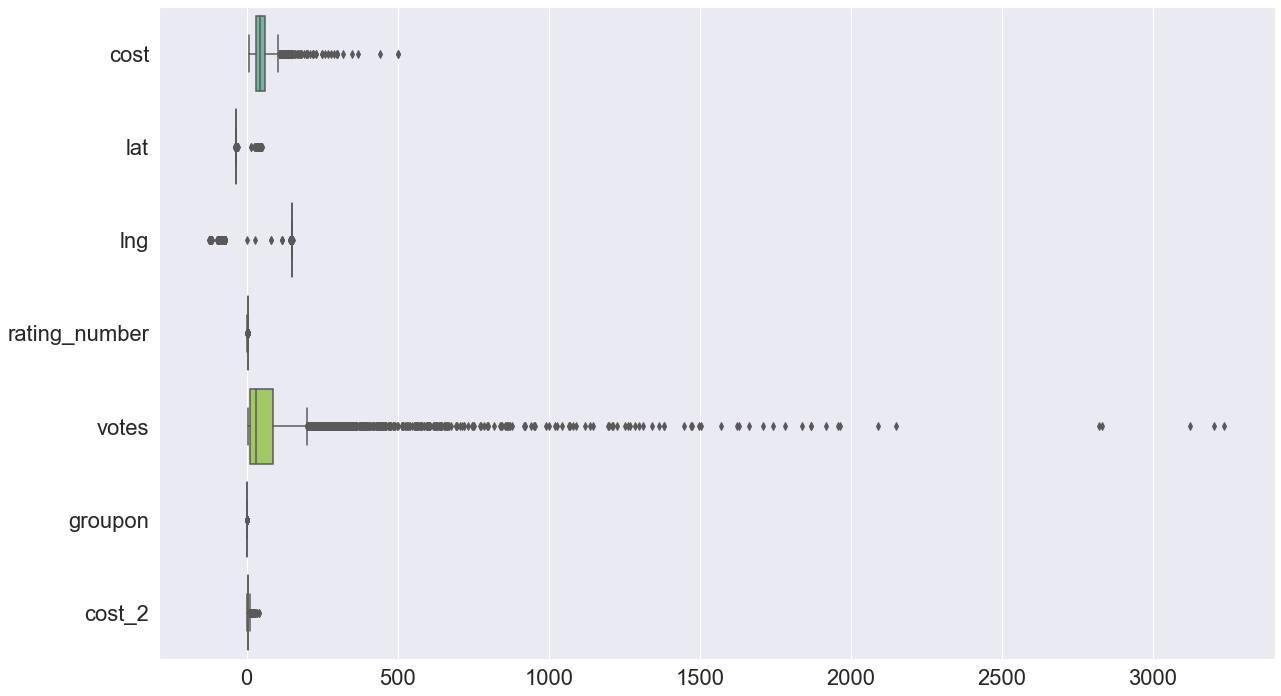

In [119]:
# pair Box plot for the numerical variables
plt.figure(figsize=(20,12))
sns.set(font_scale = 2)
ax = sns.boxplot(data=df, orient="h", palette="Set2")
plt.show()

#### All the variables appear to be free of the outlets except for 'votes', which explains the shape of its distribution, and this can be assumed as the number of voters varies with the age of the restaurant in the market. Generally, all variables will be treated.

In [120]:
# Find the percentage of missing values in each column
missing_percent = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': missing_percent})
missing_value_df

# 30% is the highest percentage of missing values in a column, thus no need to drop any.

,column_name,percent_missing
address,address,0.000000
cost,cost,3.295238
cuisine,cuisine,0.000000
lat,lat,1.828571
link,link,0.000000
lng,lng,1.828571
phone,phone,0.000000
rating_number,rating_number,31.580952
rating_text,rating_text,31.580952
subzone,subzone,0.000000


## Data Pre-processing

In [121]:
# 'Latitude' and 'longitude' columns must be treated by removing the rows that contain missing values, 
# since these two columns have constant values and cannot be replaced by derived values.
df = df[df['lat'].notna()]
df = df[df['lng'].notna()]

# Column 'rating_number' shows a clear bell shape, thus the missing values here will be replaced with the column 'Mean'.
df['rating_number'] = df['rating_number'].fillna((df['rating_number'].mean()))

# Missing values in columns 'cost', 'cost_2' and 'votes' will be replaced by the column 'Median' as they are not showing a sharp normal distribution.
df['cost'] = df['cost'].fillna((df['cost'].median()))
df['cost_2'] = df['cost_2'].fillna((df['cost_2'].median()))
df['votes'] = df['votes'].fillna((df['votes'].median()))

# Missing values in categorical variables will be replaced by the highest frequent value in each column.
for item in categorical_variables:
    df[item] = df[item].fillna(df[item].value_counts().index[0])
df.isna().sum()

# Encode the "groupon" variable to True = 1, False = 0
df["groupon"] = df["groupon"].astype(int)

In [122]:
# identify outliers with standard deviation
from numpy import mean
from numpy import std

numerical_variables_for_outliers = [i for i in numerical_variables if i not in ('lat', 'lng')]

for col in numerical_variables_for_outliers:
    
    # calculate summary statistics
    col_mean = mean(df[col])
    col_std = std(df[col])
    
    # identify outliers
    cut_off = col_std * 3
    lower = col_mean - cut_off 
    upper = col_mean + cut_off
    
    # identify outliers
    outliers = [x for x in df[col] if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    
    # remove outliers
    outliers_removed = [x for x in df[col] if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))

print()
print('Missing values by columns: ')
print(df.isna().sum())

Identified outliers: 126
Non-outlier observations: 10182
Identified outliers: 85
Non-outlier observations: 10223
Identified outliers: 159
Non-outlier observations: 10149
Identified outliers: 122
Non-outlier observations: 10186
Identified outliers: 126
Non-outlier observations: 10182

Missing values by columns: 
address          0
cost             0
cuisine          0
lat              0
link             0
lng              0
phone            0
rating_number    0
rating_text      0
subzone          0
title            0
type             0
votes            0
groupon          0
color            0
cost_2           0
cuisine_color    0
dtype: int64


In [123]:
# We have to decompose 'cuisine' and 'type' lists to be accessible and then explode the data frame
column_to_be_procc = ['cuisine', 'type']
for col in column_to_be_procc:
    df[col] = df[col].apply(lambda x: x[1:-1].strip("'").replace("'", '').replace(" ", '').split(','))
    
# explode the data frame
df = df.explode('cuisine')
df = df.explode('type')

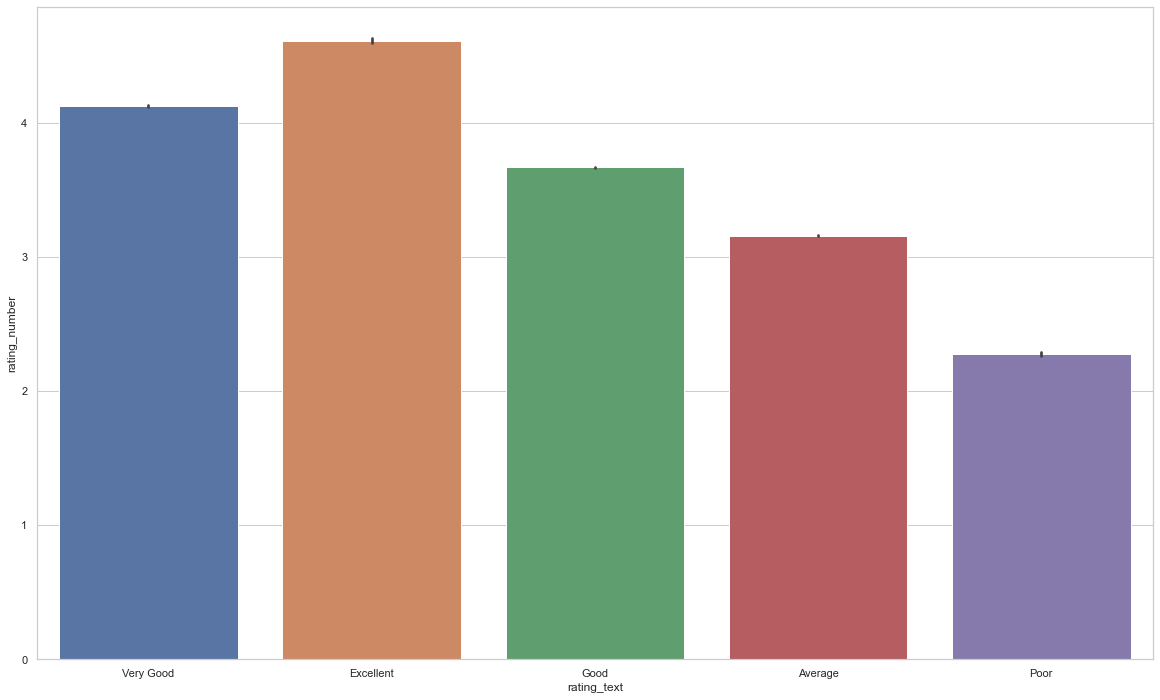

In [124]:
# bar plot for the type
plt.figure(figsize=(20,12))
sns.set(font_scale = 2)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='rating_text', y="rating_number", data=df)
plt.show()

#### In the rating_text plot, a good variation can be observed between the categories with regard to rating_number. This is good for the later modelling process.

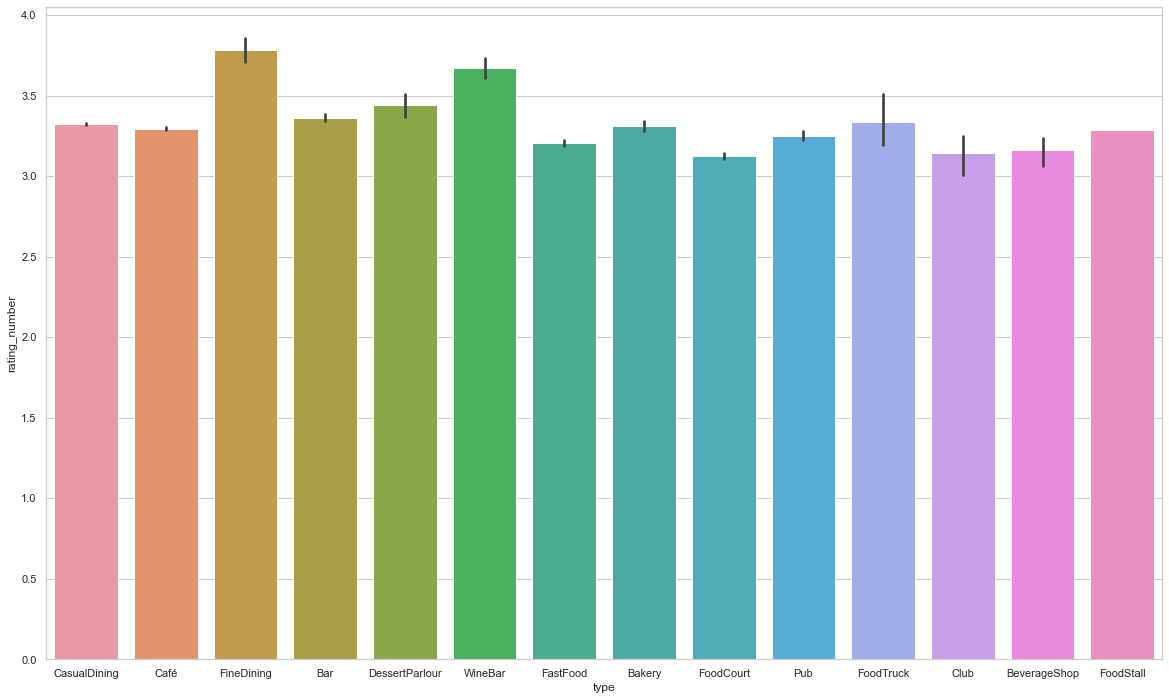

In [125]:
# bar plot for the type
plt.figure(figsize=(20,12))
sns.set(font_scale = 2)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='type', y="rating_number", data=df)
plt.show()

#### The 'type' plot shows that the rating_number does not vary with the types, which suggests that this variable will not contribute much to the prediction, and may even cause confusion.

Unique cuisines served by Sydney restaurants =  134 out of 18304


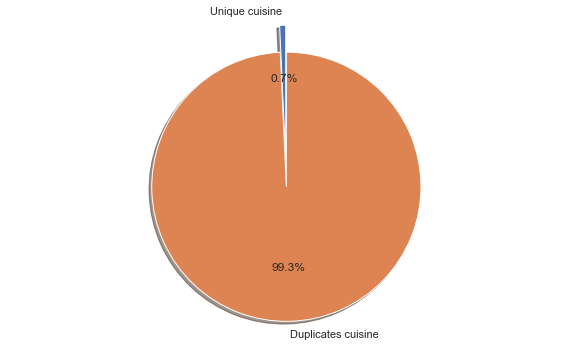

In [126]:
### 1- How many unique cuisines are served by Sydney restaurants?
unique_cuisine = len(set(df.cuisine))
duplicates_cuisine = len(df.cuisine)

print('Unique cuisines served by Sydney restaurants = ',unique_cuisine, 'out of', duplicates_cuisine)


# Pie chart
labels = 'Unique cuisine', 'Duplicates cuisine'
sizes = [unique_cuisine, duplicates_cuisine]
explode = (0, 0.2)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_facecolor("violet")
plt.show()

The Top 3 suburbs in tearms of number of restaurants are          subzone  title
61           CBD    913
462  Surry Hills    490
366   Parramatta    392


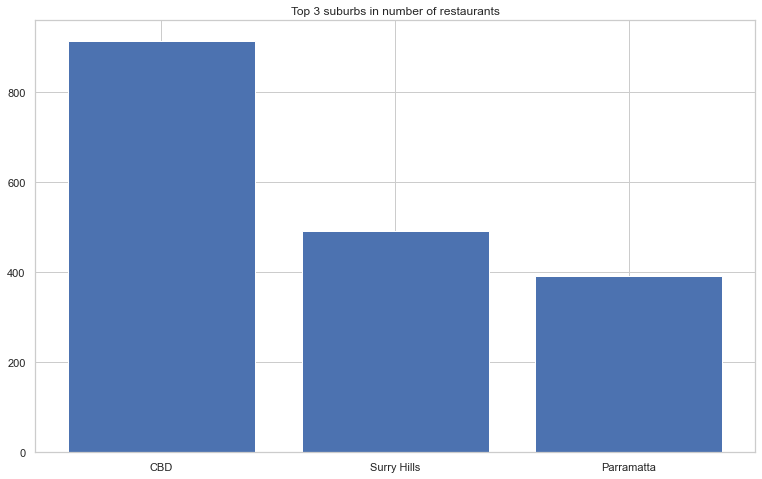

In [127]:
### 2- which suburbs (top-3) have the  highest  number of restaurants?
top_3_suburbs = pd.DataFrame(df.groupby(['subzone'], as_index= False)['title'].count())
top_3_suburbs = top_3_suburbs.sort_values('title', ascending=False).head(3)

print('The Top 3 suburbs in tearms of number of restaurants are', top_3_suburbs)

fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
x = top_3_suburbs.subzone
y = top_3_suburbs.title
ax2.bar(x, y)
plt.title("Top 3 suburbs in number of restaurants")
plt.show()


  rating_text       cost
0     Average  48.550304
1   Excellent  87.795276
2        Good  61.494482
3        Poor  57.519280
4   Very Good  72.840866


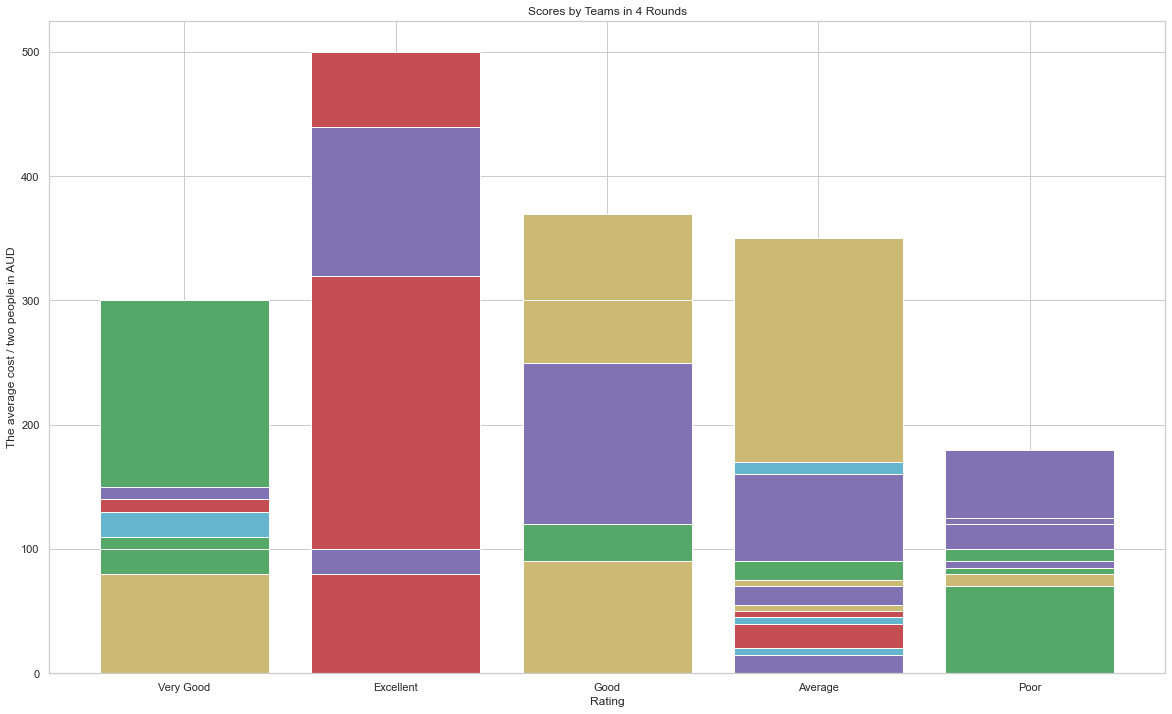

In [128]:
### 3- The variation of costs with rating.

# calculate the mean for each rating
print(df.groupby(['rating_text'], as_index= False)['cost'].mean())

# plot
x = df.rating_text
y = df.cost
bars_colors = ['r', 'g', 'c', 'm', 'y']

plt.figure(figsize=(20,12))
plt.bar(x, y, color = bars_colors)
plt.xlabel("Rating")
plt.ylabel("The average cost / two people in AUD")
plt.title("Scores by Teams in 4 Rounds")
plt.show()


### It is true, the highest-rated restaurants have the highest cost average.

In [129]:
# function to show a cuisine  density  map where each suburb is colour-coded 
# by the number of restaurants that serve a particular cuisine.

def show_cuisine_densitymap(enter_cuisine_as_str):
    import json
    # Covert the list to dataframe
    geojson_df = gpd.read_file('sydney.geojson')

    # Remove NaN
    geojson_df = geojson_df[geojson_df['geometry'].notna()]
    Geo_df = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = gpd.points_from_xy(df.lng, df.lat))

    # calculate number of resturant by cusi
    Geo_df["count"] = 1 #create count number to be summed up
    cuisine_count = Geo_df.loc[(Geo_df.cuisine == enter_cuisine_as_str)]
    cuisine_count = cuisine_count.groupby(['subzone']).sum().reset_index().drop(0)
    cuisine_count = cuisine_count[['subzone', 'count']] #select only cuisine and count
    Geo_df = Geo_df.merge(cuisine_count, left_on = 'subzone', right_on = 'subzone')
    

    Geo_df = Geo_df.merge(geojson_df, left_on = 'subzone', right_on = 'SSC_NAME')
    Geo_df = Geo_df.drop(['geometry_x', 'count_x'], axis = 1)
    Geo_df = Geo_df.rename(columns = {'geometry_y': 'geometry', 'count_y': 'count'})
    Geo_df['count'] = Geo_df['count'].fillna((Geo_df['count'].mean()))


    # finelaize befor looad to by json
    filters = ['color', 'cuisine_color', 'count','SSC_CODE','SSC_NAME','CONF_VALUE','SQKM','geometry']
    Geo_df = Geo_df[filters]
    Geo_df = gpd.GeoDataFrame(Geo_df)

    
    f_df = json.loads(Geo_df.to_json())
    final_df = json.dumps(f_df)
    NSW_cuisine = gpd.read_file(final_df)
    
    # Plot
    fig, ax = plt.subplots(figsize =(15,15), facecolor="0.4")
    geojson_df.plot(ax = ax, facecolor='lightgray', edgecolor='k', alpha = 1, linewidth = 1)
    NSW_cuisine.plot(ax = ax, color = NSW_cuisine.cuisine_color, markersize=2);
    fig.suptitle('Sydeny Restaurants Density Map By Cusine', fontsize=25, color='white')
    plt.axis('off')
    plt.show()

In [130]:
pd.unique(df.cuisine)

array(['HotPot', 'KoreanBBQ', 'BBQ', 'Korean', 'Cafe', 'CoffeeandTea',
       'Salad', 'Poké', 'Japanese', 'ModernAustralian', 'Thai',
       'Desserts', 'Cantonese', 'Chinese', 'YumCha', 'Sushi', 'Ramen',
       'Malaysian', 'Taiwanese', 'Seafood', 'Asian', 'Italian', 'Steak',
       'French', 'Singaporean', 'European', 'Mexican', 'BarFood',
       'American', 'Burger', 'Lebanese', 'Bakery', 'Grill', 'Pizza',
       'Vietnamese', 'Cuban', 'LatinAmerican', 'Irish', 'HealthyFood',
       'Australian', 'Fusion', 'Patisserie', 'Juices', 'Vegetarian',
       'JapaneseBBQ', 'Spanish', 'Dumplings', 'Indonesian', 'Indian',
       'Tapas', 'Turkish', 'Vegan', 'Shanghai', 'Tea', 'Caribbean',
       'Sandwich', 'FastFood', 'MiddleEastern', 'German', 'Mediterranean',
       'Pho', 'Greek', 'Beverages', 'Kebab', 'FishandChips', 'Moroccan',
       'Pakistani', 'SriLankan', 'PubFood', 'Contemporary', 'Teriyaki',
       'MeatPie', 'Brasserie', 'Belgian', 'Austrian', 'Hungarian',
       'Swiss', 'Char

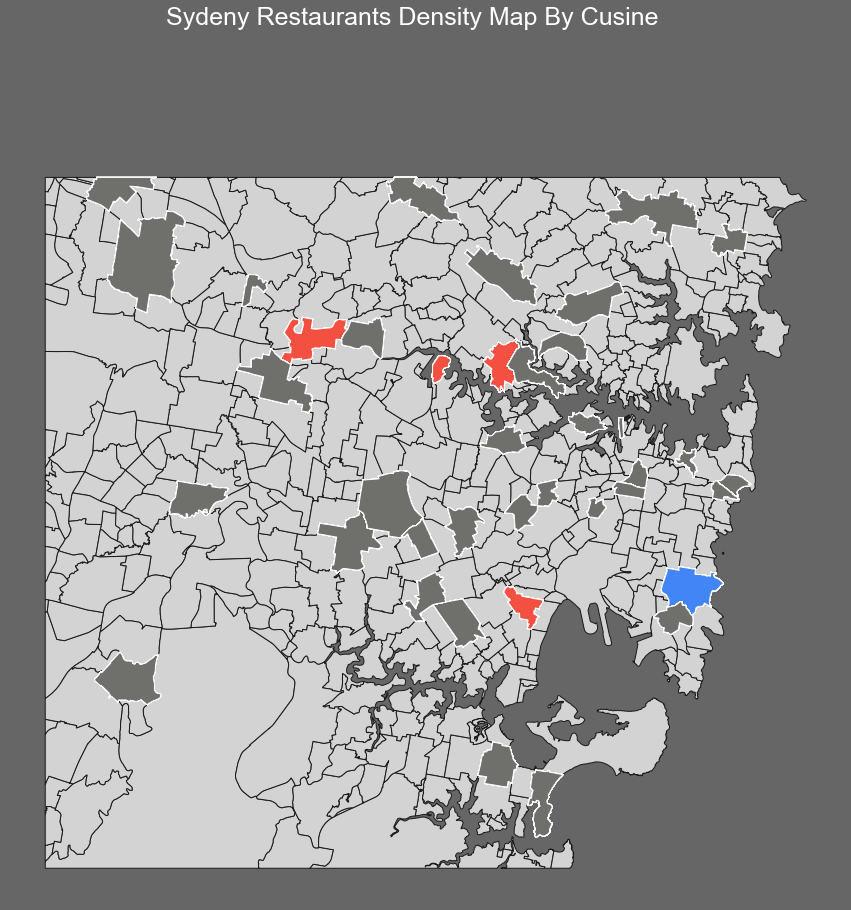

In [131]:
# Enter cuisine name as string and run to show the map
show_cuisine_densitymap('Turkish')

# Part B:

In [132]:
# # We will perform a manual Feature selection as we have a few variables
corr = df.corr()[['rating_number']].abs()
corr.style.background_gradient(cmap='coolwarm')

,rating_number
cost,0.211674
lat,0.004670
lng,0.003147
rating_number,1.000000
votes,0.532067
groupon,0.010854
cost_2,0.211674
count,nan


In [133]:
# Prepare the data for modelling

selected_feature = ['votes', 'cost', 'cost_2']
X = df[selected_feature]
y = df['rating_number']


# first keep the column name to get the DF back
norm_variables_col = X.columns

# Split the data into training = 80/ testing = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 43)


# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# get the DFs back
X_train = pd.DataFrame(X_train, columns=[norm_variables_col])

X_train.head()

,votes,cost,cost_2
0,0.008973,0.071429,0.071429
1,0.002475,0.061224,0.061224
2,0.012376,0.163265,0.163265
3,0.055693,0.040816,0.040816
4,0.074567,0.102041,0.102041


In [134]:
# Create linear regression model 1
Model_regression_1 = linear_model.LinearRegression()

# Train the model using the training sets
Model_regression_1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = Model_regression_1.predict(X_test)

# The acuraccy score
print('The Accuracy  Score: %.2f'% (Model_regression_1.score(X_test, y_test)*100).round(2))

# The mean squared error
print('linear regression model 1 Mean squared error(MSE): %.2f'% mean_squared_error(y_test, y_pred))

The Acuraccy Score: 31.33
linear regression model 1 Mean squared error(MSE): 0.10


In [135]:
# Create Gradient Descent Linear Regression model 2
class GDLinearRegression:
    def __init__(self, LR=0.0100, itera=1000):
        self.LR, self.itera = LR, itera
    
    def fit(self, X, y):
        b = 0
        m = 5
        n = X.shape[0]
        for _ in range(self.itera):
            b_grad = -2 * np.sum(y - m*X + b) / n
            m_grad = -2 * np.sum(X*(y - (m*X + b))) / n
            b = b + (self.LR * b_grad)
            m = m - (self.LR * m_grad)
        self.m, self.b = m, b
        
    def predict(self, X):
        return self.m*X + self.b

Xx = np.asfarray(X)
Yy = np.asfarray(y)

# Fit the model
GD_Model2 = GDLinearRegression()
GD_Model2.fit(Xx, Yy)

print('linear regression model 2 Mean squared error(MSE): %.2f'% mean_squared_error(y_test, y_pred))

ValueError: operands could not be broadcast together with shapes (18304,) (18304,3) 

In [113]:
# Create Gradient Descent Linear Regression model 2.2
from sklearn.linear_model import SGDRegressor
GD_Model_regression_2 = SGDRegressor()

# Train the model using the training sets
GD_Model_regression_2.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = GD_Model_regression_2.predict(X_test)

# The acuraccy score
print('The Accuracy Score: %.2f'% (GD_Model_regression_2.score(X_test, y_test)*100).round(2))

# The mean squared error
print('Mean squared error(MSE): %.2f'% mean_squared_error(y_test, y_pred))

The Acuraccy Score: 13.49
Mean squared error(MSE): 0.13


In [114]:
# semplifay the 'rating_text' column
LR_df = df
for v in range(len(LR_df['rating_text'])):
    if LR_df.iloc[v, 8] == 'Good' or LR_df.iloc[v, 8] == 'Very Good' or LR_df.iloc[v, 8] == 'Excellent':
        LR_df.iloc[v, 8] = 'Class 2'
    elif LR_df.iloc[v, 8] == 'Poor' or LR_df.iloc[v, 8] == 'Average':
        LR_df.iloc[v, 8] = 'Class 1'

In [115]:
# Prepare the data for modelling
  
# Dummy variable encoding
numerical_variables_for_modeling = [i for i in numerical_variables if i not in ['lat', 'lng']]

dummy = pd.get_dummies(data=LR_df[categorical_variables], drop_first=True)

X = dummy
y = LR_df['rating_text']

# Encode for string labels
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)


# Split the data into training = 80/ testing = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 43)

# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



print(X_train.shape)
print(y_train.shape)

(14643, 40383)
(14643,)


Confusion Matrix


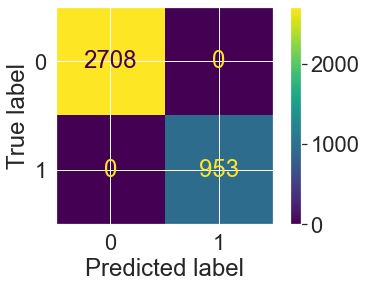

In [260]:
# Create logistic regression model 1
from sklearn.metrics import plot_confusion_matrix

# instantiate the model
model1 = LogisticRegression()

# fit the model
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)

print('Confusion Matrix')
plot_confusion_matrix(model1, X_test, y_test)

In [272]:
# Create Gradient Boosting model2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score


model4 = GradientBoostingRegressor()
model4.fit(X_train, y_train)

y_pred = model4.predict(X_test)

# The acuraccy score
print('The Acuraccy Score: %.2f'% (r2_score(y_test, y_pred)))

# The mean squared error
print('Mean squared error(MSE): %.2f'% mean_squared_error(y_test, y_pred))

The Acuraccy Score: 1.00
Mean squared error(MSE): 0.00


In [273]:
# Create Random Forest Regressor model 5
from sklearn.ensemble import RandomForestRegressor

model5 = RandomForestRegressor(n_estimators = 5, random_state = 329, min_samples_leaf = .0001)
model5.fit(X_train,y_train)

y_pred = model5.predict(X_test)


# The acuraccy score
print('The Acuraccy Score: %.2f'% (r2_score(y_test, y_pred)))

# The mean squared error
print('Mean squared error(MSE): %.2f'% mean_squared_error(y_test, y_pred))

The Acuraccy Score: 1.00
Mean squared error(MSE): 0.00


In [275]:
# Create Decision Tree Regressor model 5
from sklearn.tree import DecisionTreeRegressor


model6 = DecisionTreeRegressor(min_samples_leaf=.0001)
model6.fit(X_train,y_train)
y_pred = model6.predict(X_test)

# The acuraccy score
print('The Acuraccy Score: %.2f'% (r2_score(y_test, y_pred)))

# The mean squared error
print('Mean squared error(MSE): %.2f'% mean_squared_error(y_test, y_pred))

The Acuraccy Score: 1.00
Mean squared error(MSE): 0.00


## #The results of the models came out as expected from the analysis. Categorical variables have the best predictive effect, and this can be seen with the variation of the rating across the categories. As for the numerical variables, they had no significant correlation except for the cost variable, which even has a correlation with the rating variable below 60 percent.